In [1]:
import tweepy
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# To split the data as necessary for modelling
from sklearn.model_selection import train_test_split

# To build a simple model
from sklearn.linear_model import LogisticRegression

# To get rid of logistic regression default solver warnings that appear if sklearn hasn't been updated
import warnings
warnings.filterwarnings('ignore')

# To "pickle" things, like accuracies or even an entire fitted model
import joblib

# To cross-validate
from sklearn.model_selection import cross_val_score

# To try scaling the data in various ways
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from bs4 import BeautifulSoup
import re
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.NUMBER)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk

from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')
ENGLISH_STOP_WORDS = stopwords.words('english')

# To try dimensionality reduction
from sklearn.decomposition import PCA

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chadh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Authenticate to Twitter
auth = tweepy.OAuthHandler("OENDOLh2rnnwsUKOO6XO1WED9", 
    "opxleI1SC7wrCLDZpQXWpoDhL2ntNXvv7fSx09OiQnh9rqWStd")
auth.set_access_token("1292145515925307393-YT3Bg347EwCst3XgRS43EtLM7i9B8l", 
    "VvX4ikUwSukdZzUMyMCYa4tUM4He4craOxZXDAb5BtSDK")

api = tweepy.API(auth)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [3]:
# Setting notifier for hitting the wait limit
api = tweepy.API(auth, wait_on_rate_limit=True,
    wait_on_rate_limit_notify=True)

In [5]:
# Pulling the Republican tweets and assigning them a value of 1 in our target column

username = {'GOPLeader','SteveScalise','Jim_Jordan','RandPaul','GOP','Mike_Pence','MarshaBlackburn',
           'tedcruz','marcorubio','DanCrenshawTX','LindseyGrahamSC'}
count = 1000
total_list = []
for user in username:
    tweets = tweepy.Cursor(api.user_timeline,id=user, include_rts = True, tweet_mode = 'extended').items(count)
    tweets_list = [[tweet.created_at, tweet.full_text, user, 1] for tweet in tweets]
    total_list.extend(tweets_list)

In [6]:
# Pulling the Democratic tweets and assigning them a value of 0 in our target column

username = {'BernieSanders','JoeBiden','ewarren','PeteButtigieg',
           'KamalaHarris','JohnDelaney','amyklobuchar', 'MichaelBennet', 'AOC', 'SpeakerPelosi','TheDemocrats'}
count = 1000
for user in username:
    tweets = tweepy.Cursor(api.user_timeline,id=user, include_rts = True, tweet_mode = 'extended').items(count)
    tweets_list = [[tweet.created_at, tweet.full_text, user, 0] for tweet in tweets]
    total_list.extend(tweets_list)
    

Rate limit reached. Sleeping for: 524


In [7]:
# Turning the scrape into a dataframe and taking a look
df1 = pd.DataFrame(total_list)

In [8]:
df1

,0,1,2,3
0,2020-10-18 23:55:38,Great to see so many friends in Columbia yeste...,LindseyGrahamSC,1
1,2020-10-17 19:51:35,RT @Team_GrahamSC: No better way to spend half...,LindseyGrahamSC,1
2,2020-10-15 19:34:31,RT @JoeSColby: The promo you won’t see on C-Sp...,LindseyGrahamSC,1
3,2020-10-14 13:57:52,"RT @townhallcom: Sen. @LindseyGrahamSC:\n\n""Th...",LindseyGrahamSC,1
4,2020-10-14 13:28:22,"RT @ABC: ""It's not your job to pass judgement ...",LindseyGrahamSC,1
...,...,...,...,...
21995,2020-07-04 13:13:11,"This Independence Day, I’m grateful for our br...",KamalaHarris,0
21996,2020-07-03 23:24:00,We cannot overlook the toll this pandemic and ...,KamalaHarris,0
21997,2020-07-03 21:58:18,We cannot allow giant gig corporations to exem...,KamalaHarris,0
21998,2020-07-03 19:21:01,Trump attempted to muzzle public health expert...,KamalaHarris,0


In [9]:
# Checking Distribution
df1[3].value_counts()

1    11000
0    11000
Name: 3, dtype: int64

In [10]:
# Renaming columns and checking
df1 = df1.rename(columns = {0 : 'Timestamp of Tweet', 1 : 'Tweet Text', 2 : 'Twitter Handle', 3: 'Is Republican'})

In [11]:
df1

,Timestamp of Tweet,Tweet Text,Twitter Handle,Is Republican
0,2020-10-18 23:55:38,Great to see so many friends in Columbia yeste...,LindseyGrahamSC,1
1,2020-10-17 19:51:35,RT @Team_GrahamSC: No better way to spend half...,LindseyGrahamSC,1
2,2020-10-15 19:34:31,RT @JoeSColby: The promo you won’t see on C-Sp...,LindseyGrahamSC,1
3,2020-10-14 13:57:52,"RT @townhallcom: Sen. @LindseyGrahamSC:\n\n""Th...",LindseyGrahamSC,1
4,2020-10-14 13:28:22,"RT @ABC: ""It's not your job to pass judgement ...",LindseyGrahamSC,1
...,...,...,...,...
21995,2020-07-04 13:13:11,"This Independence Day, I’m grateful for our br...",KamalaHarris,0
21996,2020-07-03 23:24:00,We cannot overlook the toll this pandemic and ...,KamalaHarris,0
21997,2020-07-03 21:58:18,We cannot allow giant gig corporations to exem...,KamalaHarris,0
21998,2020-07-03 19:21:01,Trump attempted to muzzle public health expert...,KamalaHarris,0


In [12]:
# Saving to a CSV file so we dont have to scrape again for analysis in other books
df1.to_csv('TwitterDataScrape10182020.csv')

In [ ]:
#restart from here ###

In [9]:
df1 = pd.read_csv('TwitterDataScrape10182020.csv', index_col=0)

In [10]:
df1

,Timestamp of Tweet,Tweet Text,Twitter Handle,Is Republican
0,2020-10-18 23:55:38,Great to see so many friends in Columbia yeste...,LindseyGrahamSC,1
1,2020-10-17 19:51:35,RT @Team_GrahamSC: No better way to spend half...,LindseyGrahamSC,1
2,2020-10-15 19:34:31,RT @JoeSColby: The promo you won’t see on C-Sp...,LindseyGrahamSC,1
3,2020-10-14 13:57:52,"RT @townhallcom: Sen. @LindseyGrahamSC:\n\n""Th...",LindseyGrahamSC,1
4,2020-10-14 13:28:22,"RT @ABC: ""It's not your job to pass judgement ...",LindseyGrahamSC,1
...,...,...,...,...
21995,2020-07-04 13:13:11,"This Independence Day, I’m grateful for our br...",KamalaHarris,0
21996,2020-07-03 23:24:00,We cannot overlook the toll this pandemic and ...,KamalaHarris,0
21997,2020-07-03 21:58:18,We cannot allow giant gig corporations to exem...,KamalaHarris,0
21998,2020-07-03 19:21:01,Trump attempted to muzzle public health expert...,KamalaHarris,0


In [11]:
# Learning from our previous mistake of trying to find information from the Twitter handles
df1.drop('Twitter Handle',axis = 1, inplace = True)

In [12]:
# Checking to see if the table dropped
df1

,Timestamp of Tweet,Tweet Text,Is Republican
0,2020-10-18 23:55:38,Great to see so many friends in Columbia yeste...,1
1,2020-10-17 19:51:35,RT @Team_GrahamSC: No better way to spend half...,1
2,2020-10-15 19:34:31,RT @JoeSColby: The promo you won’t see on C-Sp...,1
3,2020-10-14 13:57:52,"RT @townhallcom: Sen. @LindseyGrahamSC:\n\n""Th...",1
4,2020-10-14 13:28:22,"RT @ABC: ""It's not your job to pass judgement ...",1
...,...,...,...
21995,2020-07-04 13:13:11,"This Independence Day, I’m grateful for our br...",0
21996,2020-07-03 23:24:00,We cannot overlook the toll this pandemic and ...,0
21997,2020-07-03 21:58:18,We cannot allow giant gig corporations to exem...,0
21998,2020-07-03 19:21:01,Trump attempted to muzzle public health expert...,0


In retrospect, it would've been smarter to save the csv file AFTER the cleaning process however let's use this as an opportunity to create a singular for loop to quickly clean the data!

In [13]:
# For loop for cleaning
prelist1 = []
prelist2 = []
prelist3 = []
for text in df1['Tweet Text']:
    souper2 = BeautifulSoup(text, "lxml")
    prelist1.append(souper2.get_text())
        
for text in prelist1:
    prelist2.append(p.clean(text))
    
for text in prelist2:
    prelist3.append(re.sub(r"^RT.*:","",text))

df1['Cleaned Tweet Text']= prelist3

In [14]:
# Check
df1

,Timestamp of Tweet,Tweet Text,Is Republican,Cleaned Tweet Text
0,2020-10-18 23:55:38,Great to see so many friends in Columbia yeste...,1,Great to see so many friends in Columbia yeste...
1,2020-10-17 19:51:35,RT @Team_GrahamSC: No better way to spend half...,1,No better way to spend halftime of the game (...
2,2020-10-15 19:34:31,RT @JoeSColby: The promo you won’t see on C-Sp...,1,The promo you wont see on C-Span. #ConfirmACB
3,2020-10-14 13:57:52,"RT @townhallcom: Sen. @LindseyGrahamSC:\n\n""Th...",1,"""This hearing to me is an opportunity to not ..."
4,2020-10-14 13:28:22,"RT @ABC: ""It's not your job to pass judgement ...",1,"""It's not your job to pass judgement on the t..."
...,...,...,...,...
21995,2020-07-04 13:13:11,"This Independence Day, I’m grateful for our br...",0,"This Independence Day, Im grateful for our bra..."
21996,2020-07-03 23:24:00,We cannot overlook the toll this pandemic and ...,0,We cannot overlook the toll this pandemic and ...
21997,2020-07-03 21:58:18,We cannot allow giant gig corporations to exem...,0,We cannot allow giant gig corporations to exem...
21998,2020-07-03 19:21:01,Trump attempted to muzzle public health expert...,0,Trump attempted to muzzle public health expert...


In [15]:
# Dropping the unclean column
df1.drop('Tweet Text',axis = 1, inplace = True)

In [16]:
# Check
df1

,Timestamp of Tweet,Is Republican,Cleaned Tweet Text
0,2020-10-18 23:55:38,1,Great to see so many friends in Columbia yeste...
1,2020-10-17 19:51:35,1,No better way to spend halftime of the game (...
2,2020-10-15 19:34:31,1,The promo you wont see on C-Span. #ConfirmACB
3,2020-10-14 13:57:52,1,"""This hearing to me is an opportunity to not ..."
4,2020-10-14 13:28:22,1,"""It's not your job to pass judgement on the t..."
...,...,...,...
21995,2020-07-04 13:13:11,0,"This Independence Day, Im grateful for our bra..."
21996,2020-07-03 23:24:00,0,We cannot overlook the toll this pandemic and ...
21997,2020-07-03 21:58:18,0,We cannot allow giant gig corporations to exem...
21998,2020-07-03 19:21:01,0,Trump attempted to muzzle public health expert...


In [17]:
# Dropping the timestamp column since we wont need it
df2 = df1.drop('Timestamp of Tweet',axis = 1)

In [18]:
# Check
df2

,Is Republican,Cleaned Tweet Text
0,1,Great to see so many friends in Columbia yeste...
1,1,No better way to spend halftime of the game (...
2,1,The promo you wont see on C-Span. #ConfirmACB
3,1,"""This hearing to me is an opportunity to not ..."
4,1,"""It's not your job to pass judgement on the t..."
...,...,...
21995,0,"This Independence Day, Im grateful for our bra..."
21996,0,We cannot overlook the toll this pandemic and ...
21997,0,We cannot allow giant gig corporations to exem...
21998,0,Trump attempted to muzzle public health expert...


In [19]:
# Setting the variables
X = df2['Cleaned Tweet Text']
y = df2['Is Republican']

In [21]:
# Creating train test split before the vectorizing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

#### Any model can be run from here - not necessarily the one that comes in order

In [43]:
# Running our most successful model from the last workbook
tfidf = TfidfVectorizer(min_df=6, stop_words=ENGLISH_STOP_WORDS)
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# fit the model
my_best_model = LogisticRegression(C=1)
my_best_model.fit(X_train_tfidf, y_train)

# extract the coefficients
coefs = my_best_model.coef_
tokens = tfidf.get_feature_names()
results = pd.DataFrame({'tokens': tokens, 'coef': coefs[0]})

# Sort the rows by the coefficient of the word/token (from lowest to highest)
results.sort_values(by='coef', inplace=True)

print("Democratic Tokens")
display(results.head(100).tokens.values)


print("Republican Tokens")
display(results.tail(100).tokens.values)

Democratic Tokens


array(['democracy', 'demconvention', 'climate', 'donald', 'familiesfirst',
       'trump', 'crisis', 'build', 'ballot', 'fitn', 'voting', 'need',
       'moment', 'racism', 'white', 'plan', 'heroesact', 'community',
       'early', 'chip', 'trumps', 'must', 'families', 'elect', 'everyone',
       'mcconnell', 'folks', 'register', 'people', 'black', 'covid',
       'lets', 'got', 'jill', 'essential', 'vote', 'fight', 'change',
       'future', 'care', 'convention', 'promise', 'mail', 'us',
       'economic', 'mask', 'bennet', 'flip', 'capitol', 'wealth',
       'everything', 'family', 'hampshire', 'works', 'country', 'leaders',
       'affordable', 'pandemic', 'systemic', 'together', 'workers',
       'health', 'manchester', 'dejoy', 'progressive', 'lgbtq', 'kick',
       'voice', 'make', 'reporters', 'ensure', 'afford', 'deeply',
       'better', 'division', 'act', 'class', 'progress', 'failed',
       'nationwide', 'paid', 'cannot', 'likely', 'minnesota', 'millions',
       'conversat

Republican Tokens


array(['constitution', '19', 'liberals', 'schiff', 'agree', 'proxy',
       'ambassador', 'enthusiasm', 'evil', 'comeback', 'reform', 'spying',
       'rate', 'patients', 'football', 'rt', 'round', 'ukraine',
       'enforcement', 'false', 'hunter', 'away', 'process', 'hospitals',
       'conservative', '100yearsofwomenssuffrage',
       'paycheckprotectionprogram', 'ok', 'jordan', 'committee', 'govt',
       'afghanistan', 'harvesting', 'judges', 'peace', 'pelosis', 'tech',
       'paycheck', 'smallbiz', 'smallbusiness', 'liberty', 'scotus',
       'operation', 'ted', 'appreciate', 'report', 'east', 'book',
       'thread', 'praying', 'psalms', 'freedom', 'israel', 'wewanttoplay',
       'pence', 'confidence', 'cuomo', 'proverbs', 'nancy', 'speaker',
       'radical', 'comey', 'whistleblower', 'carolina', 'flynn', 'fbi',
       'registered', 'socialism', 'media', 'houston', 'liberal',
       'prayers', 'cruz', 'lord', 'greatest', 'great', 'chinas', 'maga',
       'fisa', 'impeachment'

In [28]:
# Optimizing min_df parameter
dfvalue = [1,2,3,4,5,6,7,8,9,10]
nltk.download('stopwords')
ENGLISH_STOP_WORDS = stopwords.words('english')

results_df = pd.DataFrame(index=dfvalue, 
                          columns=["Training Accuracies", "Test Accuracies", "Min_DF"])
for d in dfvalue:
    tfidf = TfidfVectorizer(min_df=d, stop_words=ENGLISH_STOP_WORDS)
    tfidf.fit(X_train)
    X_train_tfidf = tfidf.transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    # fit the model
    lr_model = LogisticRegression(C=1)
    lr_model.fit(X_train_tfidf, y_train)
    
    results_df.loc[d, "Training Accuracies"] = lr_model.score(X_train_tfidf, y_train)
    results_df.loc[d, "Test Accuracies"] = lr_model.score(X_test_tfidf, y_test)
    results_df.loc[d, "Min_DF"] = d

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chadh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# display with a heatmap background
display(results_df.apply(pd.to_numeric).style.background_gradient(cmap='Blues', 
                                                                  axis=0, 
                                                                  subset = ["Training Accuracies", "Test Accuracies"]))

,Training Accuracies,Test Accuracies,Min_DF
1,0.891879,0.827273,1
2,0.888000,0.827455,2
3,0.883152,0.828182,3
4,0.880727,0.827818,4
5,0.877394,0.826545,5
6,0.874788,0.827818,6
7,0.872364,0.825636,7
8,0.869697,0.825818,8
9,0.867152,0.823091,9
10,0.864545,0.821636,10


In [32]:
# looking at the coefficients and the words 
results

,tokens,coef
1178,democracy,-4.764826
1177,demconvention,-4.476918
778,climate,-4.088613
1331,donald,-3.909582
1655,familiesfirst,-3.796348
...,...,...
1185,dems,3.298642
843,communist,3.522482
3182,pelosi,4.599541
731,china,4.748484


Let's see if we can create a wordcloud from this!

In [33]:
from wordcloud import WordCloud

In [34]:
# Resetting the index
results1 = results.reset_index()

In [35]:
# Dropping the original index
results1.drop('index', axis = 1, inplace=True)

In [36]:
results1

,tokens,coef
0,democracy,-4.764826
1,demconvention,-4.476918
2,climate,-4.088613
3,donald,-3.909582
4,familiesfirst,-3.796348
...,...,...
4884,dems,3.298642
4885,communist,3.522482
4886,pelosi,4.599541
4887,china,4.748484


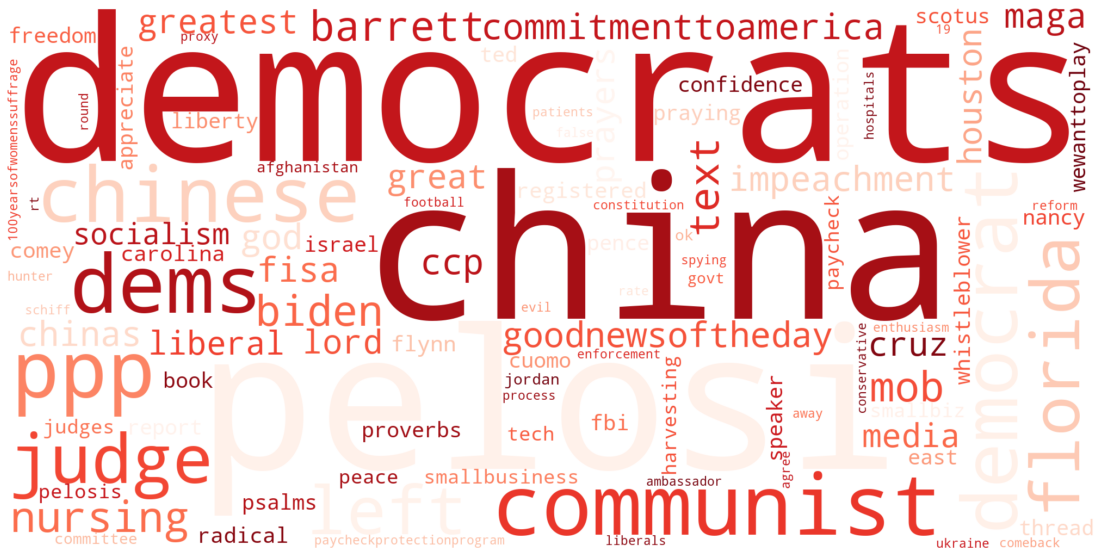

In [44]:
# Creating a loop to get the frequencies then passing it into the Wordcloud generate_from_frequencies function
w = {}
for a, x in results1.values:
    w[a] = x

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=2000, height=1000, max_words=100, background_color='white', colormap='Reds')
wordcloud.generate_from_frequencies(frequencies=w)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [38]:
results1

,tokens,coef
0,democracy,-4.764826
1,demconvention,-4.476918
2,climate,-4.088613
3,donald,-3.909582
4,familiesfirst,-3.796348
...,...,...
4884,dems,3.298642
4885,communist,3.522482
4886,pelosi,4.599541
4887,china,4.748484


In [39]:
# Creating another copy
results2 = results1.copy()

In [40]:
# Replacing the coeffs column with inverse values so that I can make a wordcloud for the Democrats as well
results2['coef'] = results1['coef']*-1

In [41]:
# Check
results2

,tokens,coef
0,democracy,4.764826
1,demconvention,4.476918
2,climate,4.088613
3,donald,3.909582
4,familiesfirst,3.796348
...,...,...
4884,dems,-3.298642
4885,communist,-3.522482
4886,pelosi,-4.599541
4887,china,-4.748484


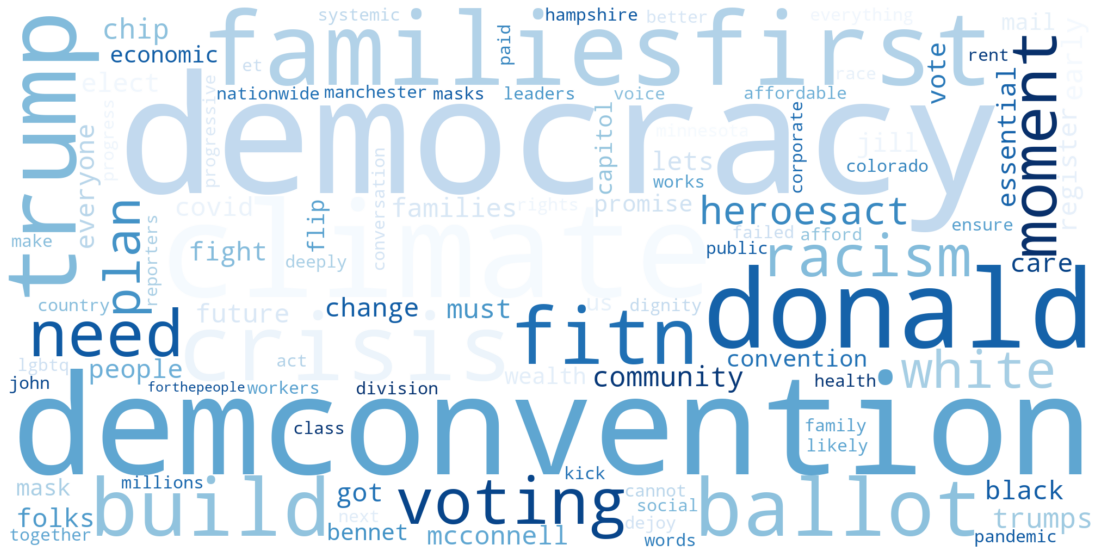

In [45]:
e = {}
for a, x in results2.values:
    e[a] = x

wordcloud2 = WordCloud(width=2000, height=1000, max_words=100, background_color='white', colormap='Blues')
wordcloud2.generate_from_frequencies(frequencies=e)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()


In [50]:
# Optimizing min_df parameter
dfvalue = [1,2,3,4,5,6,7,8,9,10]
nltk.download('stopwords')
ENGLISH_STOP_WORDS = stopwords.words('english')

results_df2 = pd.DataFrame(index=dfvalue, 
                          columns=["Training Accuracies", "Test Accuracies", "Min_DF"])
for d in dfvalue:
    tfidf = TfidfVectorizer(min_df=d, stop_words=ENGLISH_STOP_WORDS, ngram_range = (1,2))
    tfidf.fit(X_train)
    X_train_tfidf = tfidf.transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    # fit the model
    lr_model = LogisticRegression(C=1)
    lr_model.fit(X_train_tfidf, y_train)
    
    results_df2.loc[d, "Training Accuracies"] = lr_model.score(X_train_tfidf, y_train)
    results_df2.loc[d, "Test Accuracies"] = lr_model.score(X_test_tfidf, y_test)
    results_df2.loc[d, "Min_DF"] = d

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chadh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
# display with a heatmap background
display(results_df2.apply(pd.to_numeric).style.background_gradient(cmap='Blues', 
                                                                  axis=0, 
                                                                  subset = ["Training Accuracies", "Test Accuracies"]))

,Training Accuracies,Test Accuracies,Min_DF
1,0.936485,0.831818,1
2,0.914485,0.835636,2
3,0.904727,0.834000,3
4,0.897152,0.836000,4
5,0.892909,0.833818,5
6,0.888909,0.834000,6
7,0.885879,0.832545,7
8,0.882424,0.832182,8
9,0.879152,0.830000,9
10,0.876788,0.830000,10


In [22]:
# Running our most successful model from the last workbook
tfidf2 = TfidfVectorizer(min_df=4, stop_words=ENGLISH_STOP_WORDS, ngram_range = (2,2))
tfidf2.fit(X_train)
X_train_tfidf2 = tfidf2.transform(X_train)
X_test_tfidf2 = tfidf2.transform(X_test)

# fit the model
my_best_model2 = LogisticRegression(C=1)
my_best_model2.fit(X_train_tfidf2, y_train)

# extract the coefficients
coefs = my_best_model2.coef_
tokens = tfidf2.get_feature_names()
results2gram = pd.DataFrame({'tokens': tokens, 'coef': coefs[0]})

# Sort the rows by the coefficient of the word/token (from lowest to highest)
results2gram.sort_values(by='coef', inplace=True)

print("Democratic Tokens")
display(results2gram.head(100).tokens.values)

print("Republican Tokens")
display(results2gram.tail(100).tokens.values)

Democratic Tokens


array(['donald trump', 'working families', 'climate change', 'vote early',
       'make plan', 'health care', 'plan vote', 'new hampshire',
       'register vote', 'need president', 'systemic racism',
       'next president', 'voting plan', 'working people', 'donald trumps',
       'join us', 'back better', 'voting mail', 'voter suppression',
       'house passed', 'vote mail', 'pm et', 'young people', 'save lives',
       'proud endorse', 'climate crisis', 'gun violence',
       'affordable care', 'build back', 'fitn nhpolitics', 'john lewis',
       'million people', 'wear mask', 'voting rights', 'friends family',
       'come together', 'social security', 'working class', 'south bend',
       'black women', 'black brown', 'town hall', 'communities color',
       'health crisis', 'racial justice', 'contact tracing',
       'democrats ballot', 'months ago', 'voice heard', 'middle pandemic',
       'mitch mcconnell', 'soul nation', 'justice system', 'care act',
       'protect democrac

Republican Tokens


array(['rep jordan', 'double standard', 'operation warp', 'election year',
       'democrats trying', 'supply chain', 'general barr', 'karen pence',
       'exactly right', 'fisa reform', 'open schools',
       'american comeback', 'vp pence', 'chinese government',
       'michael flynn', 'china accountable', 'impeachment inquiry',
       'rt agree', 'north carolina', 'biden campaign', 'mainstream media',
       'jim jordan', 'red tape', 'american energy', 'president pence',
       'deep state', 'dr fauci', 'troops home', 'america great',
       'patriot act', 'law order', 'restore way', 'speaking minutes',
       'great american', 'death rate', 'speaking tonight', 'hong kong',
       'years president', 'high risk', 'impeach president',
       'judiciary committee', 'president zelensky', 'sure registered',
       'paycheck protection', 'rule law', 'illegal immigrants',
       'actually cared', 'information visit', 'rand paul', 'one vote',
       'million jobs', 'great country', 'pres t

In [23]:
# Optimizing min_df parameter
dfvalue = [1,2,3,4,5,6,7,8,9,10]
nltk.download('stopwords')
ENGLISH_STOP_WORDS = stopwords.words('english')

results_df3 = pd.DataFrame(index=dfvalue, 
                          columns=["Training Accuracies", "Test Accuracies", "Min_DF"])
for d in dfvalue:
    tfidf3 = TfidfVectorizer(min_df=d, stop_words=ENGLISH_STOP_WORDS, ngram_range = (2,2))
    tfidf3.fit(X_train)
    X_train_tfidf3 = tfidf3.transform(X_train)
    X_test_tfidf3 = tfidf3.transform(X_test)

    # fit the model
    lr_model3 = LogisticRegression(C=1)
    lr_model3.fit(X_train_tfidf3, y_train)
    
    results_df3.loc[d, "Training Accuracies"] = lr_model3.score(X_train_tfidf3, y_train)
    results_df3.loc[d, "Test Accuracies"] = lr_model3.score(X_test_tfidf3, y_test)
    results_df3.loc[d, "Min_DF"] = d

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chadh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# display with a heatmap background
display(results_df3.apply(pd.to_numeric).style.background_gradient(cmap='Blues', 
                                                                  axis=0, 
                                                                  subset = ["Training Accuracies", "Test Accuracies"]))

,Training Accuracies,Test Accuracies,Min_DF
1,0.978727,0.808182,1
2,0.929697,0.795818,2
3,0.887091,0.790909,3
4,0.855212,0.779636,4
5,0.831758,0.765091,5
6,0.811091,0.758727,6
7,0.796121,0.751818,7
8,0.785333,0.744727,8
9,0.774727,0.737455,9
10,0.765697,0.728545,10


In [36]:
# Optimizing min_df parameter
cvalue = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
nltk.download('stopwords')
ENGLISH_STOP_WORDS = stopwords.words('english')

results_df4 = pd.DataFrame(index=cvalue, 
                          columns=["Training Accuracies", "Test Accuracies", "C"])
for c in cvalue:
    tfidf4 = TfidfVectorizer(min_df=4, stop_words=ENGLISH_STOP_WORDS, ngram_range = (2,2))
    tfidf4.fit(X_train)
    X_train_tfidf4 = tfidf4.transform(X_train)
    X_test_tfidf4 = tfidf4.transform(X_test)

    # fit the model
    lr_model4 = LogisticRegression(C=c)
    lr_model4.fit(X_train_tfidf4, y_train)
    
    results_df4.loc[c, "Training Accuracies"] = lr_model4.score(X_train_tfidf4, y_train)
    results_df4.loc[c, "Test Accuracies"] = lr_model4.score(X_test_tfidf4, y_test)
    results_df4.loc[c, "C"] = c

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chadh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
# display with a heatmap background
display(results_df4.apply(pd.to_numeric).style.background_gradient(cmap='Blues', 
                                                                  axis=0, 
                                                                  subset = ["Training Accuracies", "Test Accuracies"]))

,Training Accuracies,Test Accuracies,C
0.0001,0.503636,0.489091,0.000100
0.001,0.534545,0.526364,0.001000
0.01,0.741636,0.718545,0.010000
0.1,0.818242,0.766364,0.100000
1.0,0.855212,0.779636,1.000000
10.0,0.881939,0.775091,10.000000
100.0,0.893636,0.763455,100.000000
1000.0,0.895758,0.763091,1000.000000
10000.0,0.896485,0.760000,10000.000000


In [41]:
results2gram.head(30)

,tokens,coef
1304,donald trump,-4.901263
5625,working families,-3.643400
806,climate change,-3.169819
5345,vote early,-2.947729
2979,make plan,-2.791995
2177,health care,-2.713891
3708,plan vote,-2.656674
3337,new hampshire,-2.651757
4101,register vote,-2.648037
3287,need president,-2.537766
